In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (
    InputLayer, Conv2D, MaxPooling2D, Flatten,
    Dense, Reshape, Conv2DTranspose, Input
)
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import epsilon
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
np.random.seed(1)
set_random_seed(1)
X = np.load('../input/olivetti_faces.npy')
y = np.load('../input/olivetti_faces_target.npy')
X = np.expand_dims(X, axis=3)
print('Shape of X : {}, Shape of y : {}'.format(X.shape, y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Shape of X : (400, 64, 64, 1), Shape of y : (400,)


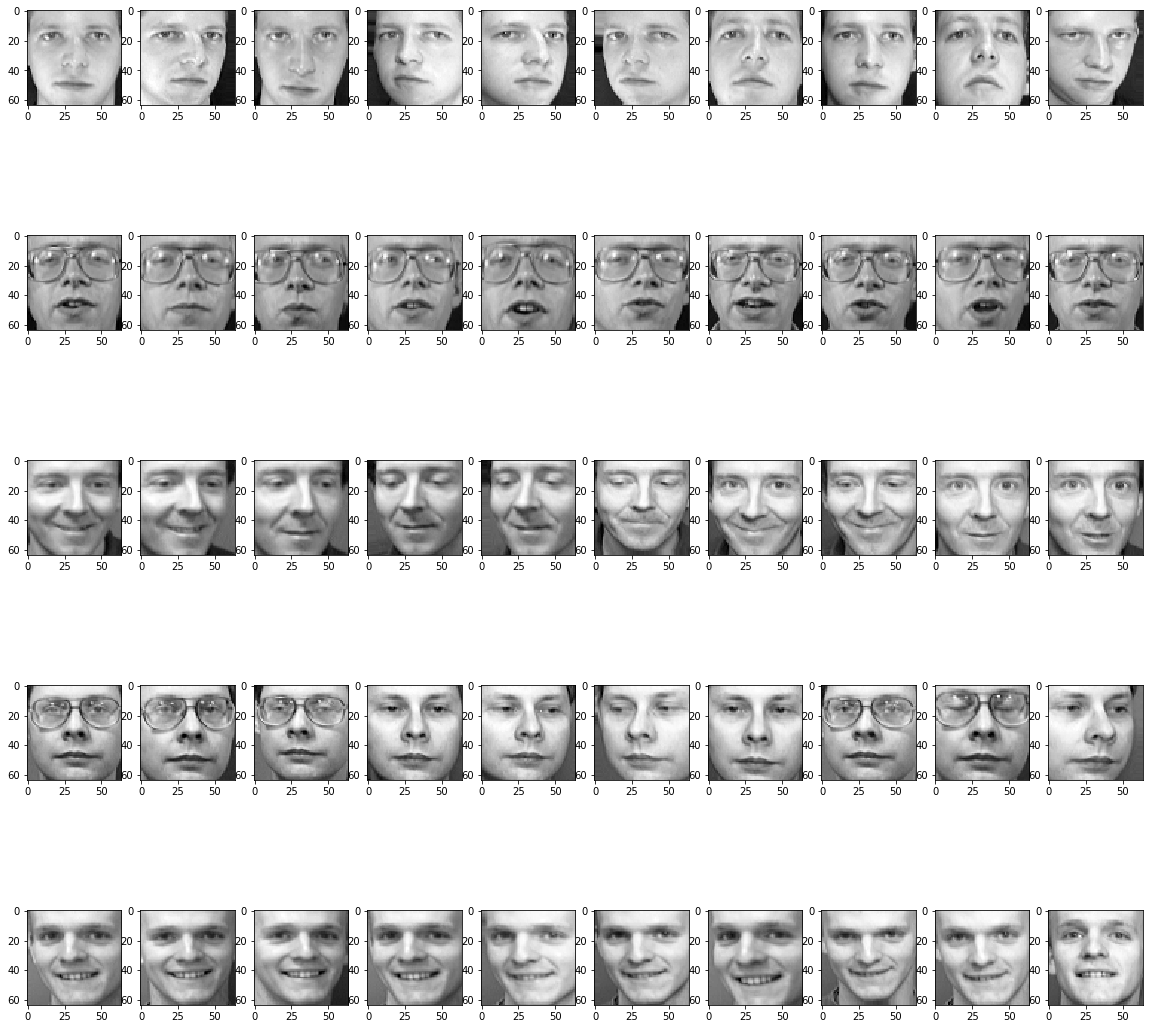

In [3]:
fig=plt.figure(figsize=(20, 20))
for i in range(5):
    for j in range(10 * i, 10 * (i + 1)):
        fig.add_subplot(5, 10, j + 1)
        plt.imshow(X[j].squeeze(), cmap='gray')
plt.show()

In [4]:
def autoencoder(img_size, code_size):
    encoder = Sequential()
    encoder.add(InputLayer(img_size))
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(Flatten())
    encoder.add(Dense(units=code_size))
    
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(units=1 * 1 * 1024))
    decoder.add(Reshape((1, 1, 1024)))
    decoder.add(Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    
    return encoder, decoder

In [5]:
encoder, decoder = autoencoder(X[0].shape, 512)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
__________

In [6]:
inp = Input(X[0].shape)
autoencoder = Model(inputs=inp, outputs=decoder(encoder(inp)))
autoencoder.compile(optimizer='adam', loss='mse')

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, 
                            horizontal_flip=True)
datagen.fit(X_train)
batch_size=32
autoencoder.fit_generator(datagen.flow(X_train, X_train, batch_size=batch_size), steps_per_epoch =
                          len(X_train) // batch_size, epochs=150, validation_data=(X_test, X_test))

Epoch 1/150
8/8 [==============================] - 7s 837ms/step - loss: 0.3334 - val_loss: 0.3062
Epoch 2/150
8/8 [==============================] - 0s 38ms/step - loss: 0.3109 - val_loss: 0.2904
Epoch 3/150
8/8 [==============================] - 0s 25ms/step - loss: 0.2832 - val_loss: 0.2708
Epoch 4/150
8/8 [==============================] - 0s 25ms/step - loss: 0.2719 - val_loss: 0.2426
Epoch 5/150
8/8 [==============================] - 0s 25ms/step - loss: 0.1959 - val_loss: 0.1266
Epoch 6/150
8/8 [==============================] - 0s 24ms/step - loss: 0.0646 - val_loss: 0.0351
Epoch 7/150
8/8 [==============================] - 0s 24ms/step - loss: 0.0295 - val_loss: 0.0303
Epoch 8/150
8/8 [==============================] - 0s 25ms/step - loss: 0.0230 - val_loss: 0.0229
Epoch 9/150
8/8 [==============================] - 0s 25ms/step - loss: 0.0195 - val_loss: 0.0216
Epoch 10/150
8/8 [==============================] - 0s 25ms/step - loss: 0.0180 - val_loss: 0.0204
Epoch 11/150
8/8 [

In [7]:
def normalize(X, mean, std):
    return (X - mean) / (std + epsilon())

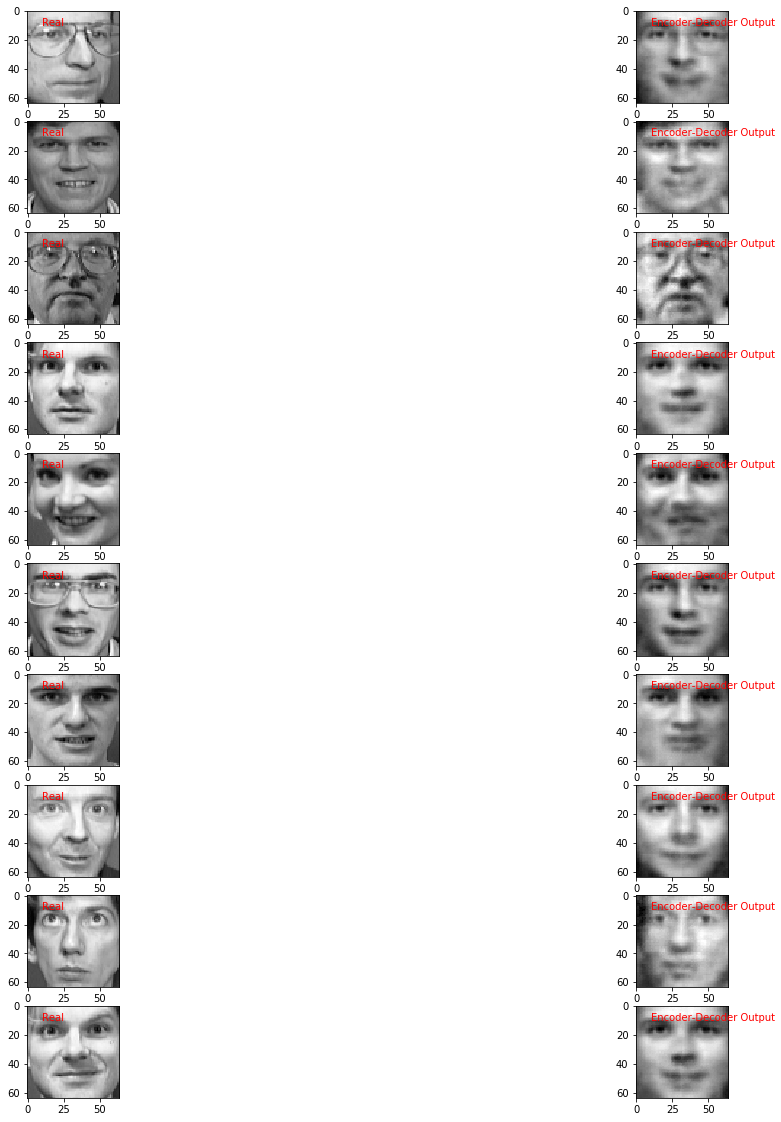

In [12]:
reconstructed = autoencoder.predict(normalize(X_test, datagen.mean, datagen.std))
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    fig.add_subplot(10, 2, 2 * i - 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.text(10, 10, 'Real', color='red')  
    fig.add_subplot(10, 2, 2 * i)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.text(10, 10, 'Encoder-Decoder Output', color='red')  
plt.show()


In [9]:
classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')
classifier.fit(encoder.predict(normalize(X_train, datagen.mean, datagen.std)), y_train)
print('Test set accuracy : {}%'.format(classifier.score(encoder.predict(normalize(
    X_test, datagen.mean, datagen.std)), y_test) * 100))

Test set accuracy : 80.83333333333333%
